In [2]:
import os
import time
import pickle
import requests
import pyvo as vo
import numpy as np
import pandas as pd
from tqdm import tqdm
import concurrent.futures
import matplotlib.pyplot as plt
from urllib3.util.retry import Retry
from scipy.interpolate import interp1d
from requests.adapters import HTTPAdapter
import astropy.units as u
from astropy.io import fits
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord

"Important:  Gaia archive will be intermittently unavailable due to scheduled maintenance on 10-12-2024 from 08:00 to 10:00 (CET)"


# Getting Simbad Labels
### Separated in 4 queries to avoid tap limit of 2 Million Objects

In [ ]:
query1 = simbad.query_tap("""SELECT oid, otype
FROM basic
WHERE (otype = 'MS*' OR otype = 'Be*' OR otype = 'BS*' OR otype = 'SX*' OR otype = 'gD*' OR otype = 'dS*' OR otype = 'Ma*' OR otype = 'bC*' OR otype = 'sg*' \
OR otype = 's*r' OR otype = 's*y' OR otype = 's*b' OR otype = 'WR*' OR otype = 'N*' OR otype = 'Psr' OR otype = 'Y*O' OR otype = 'Or*' OR otype = 'TT*' OR  \
otype = 'Ae*' OR otype = 'out' OR otype = 'HH' OR otype = 'Ev*' OR otype = 'RG*' OR otype = 'HS*' OR otype = 'HB*' OR otype = 'RR*' OR otype = 'WV*' OR otype = 'Ce*' \
OR otype = 'cC*' OR otype = 'C*' OR otype = 'S*' OR otype = 'LP*' OR otype = 'AB*' OR otype = 'Mi*' OR otype = 'OH*' OR otype = 'pA*' OR otype = 'RV*' OR otype = 'PN' \
OR otype = 'WD*' OR otype = 'Pe*' OR otype = 'a2*' OR otype = 'RC*' OR otype = 'EB*' OR otype = 'El*' OR otype = 'SB*' OR otype = 'RS*' OR otype = 'BY*' OR otype = 'Sy*' \
OR otype = 'XB*' OR otype = 'LXB' OR otype = 'HXB' OR otype = 'CV*' OR otype = 'No*' OR otype = '**' OR otype = 'SN*' OR otype = 'LM*' OR otype = 'BD*' OR otype = 'Ir*' \
OR otype = 'Er*' OR otype = 'Ro*' OR otype = 'Pu*' OR otype = 'Em*' OR otype = 'PM*' OR otype = 'HV*') AND (pmra < 0 ) AND (pmdec < -4)""", maxrec=2000000) 

In [ ]:
query2 = Simbad.query_tap("""SELECT oid, otype
FROM basic
WHERE (otype = 'MS*' OR otype = 'Be*' OR otype = 'BS*' OR otype = 'SX*' OR otype = 'gD*' OR otype = 'dS*' OR otype = 'Ma*' OR otype = 'bC*' OR otype = 'sg*' \
OR otype = 's*r' OR otype = 's*y' OR otype = 's*b' OR otype = 'WR*' OR otype = 'N*' OR otype = 'Psr' OR otype = 'Y*O' OR otype = 'Or*' OR otype = 'TT*' OR  \
otype = 'Ae*' OR otype = 'out' OR otype = 'HH' OR otype = 'Ev*' OR otype = 'RG*' OR otype = 'HS*' OR otype = 'HB*' OR otype = 'RR*' OR otype = 'WV*' OR otype = 'Ce*' \
OR otype = 'cC*' OR otype = 'C*' OR otype = 'S*' OR otype = 'LP*' OR otype = 'AB*' OR otype = 'Mi*' OR otype = 'OH*' OR otype = 'pA*' OR otype = 'RV*' OR otype = 'PN' \
OR otype = 'WD*' OR otype = 'Pe*' OR otype = 'a2*' OR otype = 'RC*' OR otype = 'EB*' OR otype = 'El*' OR otype = 'SB*' OR otype = 'RS*' OR otype = 'BY*' OR otype = 'Sy*' \
OR otype = 'XB*' OR otype = 'LXB' OR otype = 'HXB' OR otype = 'CV*' OR otype = 'No*' OR otype = '**' OR otype = 'SN*' OR otype = 'LM*' OR otype = 'BD*' OR otype = 'Ir*' \
OR otype = 'Er*' OR otype = 'Ro*' OR otype = 'Pu*' OR otype = 'Em*' OR otype = 'PM*' OR otype = 'HV*') AND (pmra < 0 ) AND (pmdec >= -4)""", maxrec=2000000) 

In [ ]:
query3 = Simbad.query_tap("""SELECT oid, otype
FROM basic
WHERE (otype = 'MS*' OR otype = 'Be*' OR otype = 'BS*' OR otype = 'SX*' OR otype = 'gD*' OR otype = 'dS*' OR otype = 'Ma*' OR otype = 'bC*' OR otype = 'sg*' \
OR otype = 's*r' OR otype = 's*y' OR otype = 's*b' OR otype = 'WR*' OR otype = 'N*' OR otype = 'Psr' OR otype = 'Y*O' OR otype = 'Or*' OR otype = 'TT*' OR  \
otype = 'Ae*' OR otype = 'out' OR otype = 'HH' OR otype = 'Ev*' OR otype = 'RG*' OR otype = 'HS*' OR otype = 'HB*' OR otype = 'RR*' OR otype = 'WV*' OR otype = 'Ce*' \
OR otype = 'cC*' OR otype = 'C*' OR otype = 'S*' OR otype = 'LP*' OR otype = 'AB*' OR otype = 'Mi*' OR otype = 'OH*' OR otype = 'pA*' OR otype = 'RV*' OR otype = 'PN' \
OR otype = 'WD*' OR otype = 'Pe*' OR otype = 'a2*' OR otype = 'RC*' OR otype = 'EB*' OR otype = 'El*' OR otype = 'SB*' OR otype = 'RS*' OR otype = 'BY*' OR otype = 'Sy*' \
OR otype = 'XB*' OR otype = 'LXB' OR otype = 'HXB' OR otype = 'CV*' OR otype = 'No*' OR otype = '**' OR otype = 'SN*' OR otype = 'LM*' OR otype = 'BD*' OR otype = 'Ir*' \
OR otype = 'Er*' OR otype = 'Ro*' OR otype = 'Pu*' OR otype = 'Em*' OR otype = 'PM*' OR otype = 'HV*') AND (pmra >= 0) AND (pmdec < -3)""", maxrec=2000000) 

In [ ]:
query4 = Simbad.query_tap("""SELECT oid, otype
FROM basic
WHERE (otype = 'MS*' OR otype = 'Be*' OR otype = 'BS*' OR otype = 'SX*' OR otype = 'gD*' OR otype = 'dS*' OR otype = 'Ma*' OR otype = 'bC*' OR otype = 'sg*' \
OR otype = 's*r' OR otype = 's*y' OR otype = 's*b' OR otype = 'WR*' OR otype = 'N*' OR otype = 'Psr' OR otype = 'Y*O' OR otype = 'Or*' OR otype = 'TT*' OR  \
otype = 'Ae*' OR otype = 'out' OR otype = 'HH' OR otype = 'Ev*' OR otype = 'RG*' OR otype = 'HS*' OR otype = 'HB*' OR otype = 'RR*' OR otype = 'WV*' OR otype = 'Ce*' \
OR otype = 'cC*' OR otype = 'C*' OR otype = 'S*' OR otype = 'LP*' OR otype = 'AB*' OR otype = 'Mi*' OR otype = 'OH*' OR otype = 'pA*' OR otype = 'RV*' OR otype = 'PN' \
OR otype = 'WD*' OR otype = 'Pe*' OR otype = 'a2*' OR otype = 'RC*' OR otype = 'EB*' OR otype = 'El*' OR otype = 'SB*' OR otype = 'RS*' OR otype = 'BY*' OR otype = 'Sy*' \
OR otype = 'XB*' OR otype = 'LXB' OR otype = 'HXB' OR otype = 'CV*' OR otype = 'No*' OR otype = '**' OR otype = 'SN*' OR otype = 'LM*' OR otype = 'BD*' OR otype = 'Ir*' \
OR otype = 'Er*' OR otype = 'Ro*' OR otype = 'Pu*' OR otype = 'Em*' OR otype = 'PM*' OR otype = 'HV*') AND (pmra >= 0) AND (pmdec >= -3)""", maxrec=2000000) 

### Checking it worked and combining datasets

In [ ]:
# Print length of each query
print(len(query1))
print(len(query2))
print(len(query3))
print(len(query4))

# Print total length of all queries
print('Number of stars in all queries: ', len(query1) + len(query2) + len(query3) + len(query4))

# Make into a dataframe and concatenate
df1 = query1.to_pandas()
df2 = query2.to_pandas()
df3 = query3.to_pandas()
df4 = query4.to_pandas()

df = pd.concat([df1, df2, df3, df4])

# Getting all IDs of the object (Including Gaia)

In [ ]:
ids1 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref < 2000000""", maxrec=2000000) 
ids1 = ids1.to_pandas()
ids2 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 2000000 AND oidref < 4000000""", maxrec=2000000)
ids2 = ids2.to_pandas()
ids3 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 4000000 AND oidref < 6000000""", maxrec=2000000)
ids3 = ids3.to_pandas()
ids4 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 6000000 AND oidref < 8000000""", maxrec=2000000)
ids4 = ids4.to_pandas()
ids5 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 8000000 AND oidref < 10000000""", maxrec=2000000)
ids5 = ids5.to_pandas()
ids6 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 10000000 AND oidref < 12000000""", maxrec=2000000)
ids6 = ids6.to_pandas()
ids7 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 12000000 AND oidref < 14000000""", maxrec=2000000)
ids7 = ids7.to_pandas()
ids8 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 14000000 AND oidref < 16000000""", maxrec=2000000)
ids8 = ids8.to_pandas()
ids9 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 16000000 AND oidref < 18000000""", maxrec=2000000)
ids9 = ids9.to_pandas()
ids10 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 18000000 AND oidref < 20000000""", maxrec=2000000)
ids10 = ids10.to_pandas()
# Save the dataframes to a concatenated csv file and delete the dataframes
ids1.to_csv('ids.csv', index=False)
ids2.to_csv('ids.csv', mode='a', header=False, index=False)
ids3.to_csv('ids.csv', mode='a', header=False, index=False)
ids4.to_csv('ids.csv', mode='a', header=False, index=False)
ids5.to_csv('ids.csv', mode='a', header=False, index=False)
ids6.to_csv('ids.csv', mode='a', header=False, index=False)
ids7.to_csv('ids.csv', mode='a', header=False, index=False)
ids8.to_csv('ids.csv', mode='a', header=False, index=False)
ids9.to_csv('ids.csv', mode='a', header=False, index=False)
ids10.to_csv('ids.csv', mode='a', header=False, index=False)

del ids1, ids2, ids3, ids4, ids5, ids6, ids7, ids8, ids9, ids10
gc.collect()


In [ ]:
ids11 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 20000000 AND oidref < 22000000""", maxrec=2000000)
ids11 = ids11.to_pandas()
ids12 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 22000000 AND oidref < 24000000""", maxrec=2000000)
ids12 = ids12.to_pandas()
ids13 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 24000000 AND oidref < 26000000""", maxrec=2000000)
ids13 = ids13.to_pandas()
ids14 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 26000000 AND oidref < 28000000""", maxrec=2000000)
ids14 = ids14.to_pandas()
ids15 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 28000000 AND oidref < 30000000""", maxrec=2000000)
ids15 = ids15.to_pandas()
ids16 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 30000000 AND oidref < 32000000""", maxrec=2000000)
ids16 = ids16.to_pandas()
ids17 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 32000000 AND oidref < 34000000""", maxrec=2000000)
ids17 = ids17.to_pandas()
ids18 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 34000000 AND oidref < 36000000""", maxrec=2000000)
ids18 = ids18.to_pandas()
ids19 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 36000000 AND oidref < 38000000""", maxrec=2000000)
ids19 = ids19.to_pandas()
ids20 = simbad.query_tap("""SELECT oidref, ids
FROM ids
WHERE oidref >= 38000000 AND oidref < 40000000""", maxrec=2000000)
ids20 = ids20.to_pandas()
# Save the dataframes to a concatenated csv file and delete the dataframes
ids11.to_csv('ids.csv', mode='a', header=False, index=False)
ids12.to_csv('ids.csv', mode='a', header=False, index=False)
ids13.to_csv('ids.csv', mode='a', header=False, index=False)
ids14.to_csv('ids.csv', mode='a', header=False, index=False)
ids15.to_csv('ids.csv', mode='a', header=False, index=False)
ids16.to_csv('ids.csv', mode='a', header=False, index=False)
ids17.to_csv('ids.csv', mode='a', header=False, index=False)
ids18.to_csv('ids.csv', mode='a', header=False, index=False)
ids19.to_csv('ids.csv', mode='a', header=False, index=False)
ids20.to_csv('ids.csv', mode='a', header=False, index=False)

del ids11, ids12, ids13, ids14, ids15, ids16, ids17, ids18, ids19, ids20
gc.collect()

### Sanity Check

In [ ]:
# Open the csv file and read it into a dataframe
ids = pd.read_csv('ids.csv')
print(ids.shape)

## Match ids to each star

In [ ]:
# Inner join the dataframes on the oidref column
dfmerge = df.merge(ids, left_on='oid', right_on='oidref', how='inner')
print(dfmerge.shape)
print(df.shape)

# Note they should match

# Print the number of stars in each category
print('Number of stars in each category: ')
counts = dfmerge['otype'].value_counts()
print(counts)

# Save the data
dfmerge.to_csv("all_stars.csv", index=False)

# Get the gaia photometry and astrometry

In [ ]:
def GetGAIAData(GaiaDR3SourceIDs):
    try:
        qry = f"SELECT * FROM gaiadr3.gaia_source gs WHERE gs.source_id in ({GaiaDR3SourceIDs});"
        job = Gaia.launch_job_async(qry)
        tblGaia = job.get_results()
        dfGaia = tblGaia.to_pandas()
        return dfGaia
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

def split_ids_into_chunks(id_string, chunk_size=50000):
    id_list = id_string.split(', ')
    chunks = [', '.join(id_list[i:i + chunk_size]) for i in range(0, len(id_list), chunk_size)]
    return chunks

In [ ]:
# Load the DataFrame
simbad_data = pd.read_csv("all_stars.csv")

# Filter SIMBAD data to only include rows where 'ids' contains 'Gaia DR3'
simbad_data['gaia_id'] = simbad_data['ids'].apply(lambda x: next((id for id in x.split('|') if id.startswith('Gaia DR3')), None))

# Remove 'Gaia DR3' prefix and drop rows with NaN values in 'gaia_id'
simbad_data['gaia_id'] = simbad_data['gaia_id'].str.lstrip('Gaia DR3')
simbad_data = simbad_data.dropna(subset=['gaia_id'])

# Ensure 'gaia_id' is a string
simbad_data['gaia_id'] = simbad_data['gaia_id'].astype(str)

# Split the Gaia DR3 source IDs into chunks of 30,000 IDs each
GaiaDR3SourceIDs = ', '.join(simbad_data['gaia_id'].astype(str))
chunks = split_ids_into_chunks(GaiaDR3SourceIDs)

# Initialize an empty DataFrame to store all data
combined_df = pd.DataFrame()

# Process each chunk and append the results to the combined DataFrame
for chunk in chunks:
    dfGaia = GetGAIAData(chunk)
    combined_df = pd.concat([combined_df, dfGaia], ignore_index=True)

# Convert the combined DataFrame to a NumPy array if needed
combined_matrix = combined_df.to_numpy()

# GAIA data
gaia_data = combined_df[["source_id", "ra", "ra_error", "dec", "dec_error", "phot_g_mean_flux", "phot_g_mean_flux_error", "pmra", "pmra_error", "pmdec", "pmdec_error", "parallax", "parallax_error", "phot_bp_mean_flux", "phot_bp_mean_flux_error", "phot_rp_mean_flux", "phot_rp_mean_flux_error"]]

# Convert Gaia source_id to string
gaia_data['source_id'] = gaia_data['source_id'].astype(str)

# Merge Gaia and SIMBAD data on matching IDs
star_data = pd.merge(gaia_data, simbad_data, left_on='source_id', right_on='gaia_id', how='inner')
star_data.to_pickle("star_data.pkl")

In [ ]:
# open star_data.pkl
star_data = pd.read_pickle("star_data.pkl")

# print otypes
print(star_data["otype"].value_counts())

# Download the Lamost spectras (Scraping)

In [2]:
# Function to download a file with retries
def download_file(url):
    file_name = os.path.join(save_folder, url.split('/')[-1])
    
    # If the file already exists, return success
    if os.path.exists(file_name):
        return True, file_name
    
    # Retry mechanism
    retries = Retry(total=5, backoff_factor=1, status_forcelist=[429, 500, 502, 503, 504])
    session = requests.Session()
    session.mount('https://', HTTPAdapter(max_retries=retries))

    try:
        response = session.get(url)
        response.raise_for_status()  # Check for HTTP errors
        
        # Save the file content
        with open(file_name, 'wb') as f:
            f.write(response.content)
        
        return True, file_name  # Success
    except requests.HTTPError as e:
        return False, f"Failed to download {url}: {e}"  # Failure
    except Exception as e:
        return False, f"Other error occurred: {e}"

# Main function to download all files
def download_all_files(urls):
    success_count = 0
    failure_count = 0

    # Reduce the number of threads to avoid overwhelming the network
    with concurrent.futures.ThreadPoolExecutor(max_workers=300) as executor:
        # Create a progress bar with the total number of URLs
        with tqdm(total=len(urls), desc="Downloading", unit="file") as pbar:
            futures = {executor.submit(download_file, url): url for url in urls}
            
            for future in concurrent.futures.as_completed(futures):
                success, result = future.result()
                pbar.update(1)  # Update the progress bar for each completed download
                
                if success:
                    success_count += 1
                else:
                    failure_count += 1
                    #print(f"Error: {result}")

    # Print final counts for successful and failed downloads
    print(f"\nDownload complete! Successfully downloaded: {success_count}, Failed: {failure_count}")

In [3]:
# Load your STAR data and LAMOST catalog (assuming you have a local CSV or FITS file for LAMOST)
star_data = pd.read_pickle("star_data.pkl")  # Loaded STAR data
lamost_catalog = pd.read_csv("dr9_v2.0_LRS_catalogue.csv")  # Assuming CSV format for LAMOST catalog

# Ensure that RA and Dec columns are numeric and have units
star_data['ra'] = pd.to_numeric(star_data['ra'], errors='coerce')  # Coerce non-numeric to NaN
star_data['dec'] = pd.to_numeric(star_data['dec'], errors='coerce')
lamost_catalog['ra'] = pd.to_numeric(lamost_catalog['ra'], errors='coerce')
lamost_catalog['dec'] = pd.to_numeric(lamost_catalog['dec'], errors='coerce')

# Drop rows with NaN values in RA or Dec
star_data = star_data.dropna(subset=['ra', 'dec'])
lamost_catalog = lamost_catalog.dropna(subset=['ra', 'dec'])

# Convert STAR and LAMOST data to SkyCoord objects for crossmatching
star_coords = SkyCoord(ra=star_data['ra'].values*u.deg, dec=star_data['dec'].values*u.deg)
lamost_coords = SkyCoord(ra=lamost_catalog['ra'].values*u.deg, dec=lamost_catalog['dec'].values*u.deg)

# Perform the crossmatch using astropy's match_to_catalog_sky function
idx, d2d, _ = star_coords.match_to_catalog_sky(lamost_coords)

# Define a matching radius
match_radius = 1 * u.arcsec
matches = d2d < match_radius

# Filter the matches
matched_star = star_data.iloc[matches]
matched_lamost = lamost_catalog.iloc[idx[matches]]

# Combine matched data
star_lamost_data = pd.concat([matched_star.reset_index(drop=True), matched_lamost.reset_index(drop=True)], axis=1)

# Save the crossmatched data
star_lamost_data.to_pickle("star_lamost_data.pkl")

print(f"Number of matches: {star_lamost_data.shape[0]}")
print("out of ", star_data.shape[0])
del star_data, lamost_catalog

Number of matches: 384629
out of  3845419


In [ ]:
# Load the crossmatched data
star_lamost_data = pd.read_pickle("star_lamost_data.pkl")
obsid_list = star_lamost_data['obsid'].values

# Specify the folder to save the files
save_folder = "star_spectra"

# Create the folder if it doesn't exist
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# List of URLs to download (assuming obsid_list is available)
urls = [f"https://www.lamost.org/dr7/v2.0/spectrum/fits/{obsid}" for obsid in obsid_list]

# Call the function to start downloading
download_all_files(urls)

# Free up memory by deleting the large DataFrame
del star_lamost_data

Downloading:  53%|█████▎    | 204017/384629 [5:09:18<591:00:55, 11.78s/file] 

# Prep Gaia Lamost Data Fusion

In [4]:
# star directory
directory = 'star_spectra/'

# Get a list of all files in the directory
id_train_star = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

# Print the number of files
print('Number of STAR spectra:', len(id_train_star))

Number of STAR spectra: 136178


In [5]:
lamost_catalog = pd.read_csv("dr9_v2.0_LRS_catalogue.csv")  # Assuming CSV format for LAMOST catalog

In [6]:
# Time how long it takes for the crossmatch
start_time = time.time()

obsid_list = id_train_star
obsid_list = [int(obsid) for obsid in obsid_list]

# Filter the DataFrame
filtered_df = lamost_catalog[lamost_catalog['obsid'].isin(obsid_list)]

# Get the 'ra' and 'dec' values
ra_dec_values = filtered_df[['ra', 'dec']]
print(ra_dec_values)    

# Load your GAL data and LAMOST catalog (assuming you have a local CSV or FITS file for LAMOST)
star_data = pd.read_pickle("star_data.pkl")  # Loaded STAR data

# Ensure that RA and Dec columns are numeric and have units
star_data['ra'] = pd.to_numeric(star_data['ra'], errors='coerce')  # Coerce non-numeric to NaN
star_data['dec'] = pd.to_numeric(star_data['dec'], errors='coerce')

# Drop rows with NaN values in 'ra' and 'dec' columns
star_data = star_data.dropna(subset=['ra', 'dec'])
ra_dec_values = filtered_df[['obsid','ra', 'dec']]

# Convert GAL and LAMOST data to SkyCoord objects for crossmatching
star_coords = SkyCoord(ra=star_data['ra'].values*u.deg, dec=star_data['dec'].values*u.deg)
lamost_coords = SkyCoord(ra=ra_dec_values['ra'].values*u.deg, dec=ra_dec_values['dec'].values*u.deg)

# Crossmatch the GAL and LAMOST data
idx, d2d, _ = star_coords.match_to_catalog_sky(lamost_coords)

# Define a matching radius
match_radius = 1 * u.arcsec
matches = d2d < match_radius

# Filter the matches
matched_star = star_data.iloc[matches]
matched_lamost = ra_dec_values.iloc[idx[matches]]

# Combine the matched data
matched_data = pd.concat([matched_star.reset_index(drop=True), matched_lamost.reset_index(drop=True)], axis=1)

######################################################################################################################
# Print time taken for crossmatch
print("--- %s seconds ---" % (time.time() - start_time))

                  ra        dec
99        332.098588  -1.259508
135       332.087160  -2.039786
435       331.310760   0.145980
452       331.312840   0.914318
499       332.425814   0.696325
...              ...        ...
10686863  277.662760  11.637670
10686879  276.872710  11.871802
10686896  277.306960  11.241274
10686899  277.242780  11.204973
10686918  276.793290  11.188747

[136178 rows x 2 columns]
--- 13.1575288772583 seconds ---


In [7]:
print(f"Number of matches: {matched_data.shape[0]}")

Number of matches: 136225


In [8]:
# print head of matched data
print(matched_data.head())

           source_id         ra  ra_error        dec  dec_error  \
0  15947527103311232  51.869472  0.016734  10.698907   0.013360   
1  20434908934166912  42.834464  0.033320   8.182195   0.026800   
2  42611749230202624  52.806775  0.014411  15.872815   0.011149   
3  50912374823455104  58.416484  0.019283  19.530629   0.011572   
4  59776770710183936  46.128963  0.127650  19.070242   0.107538   

   phot_g_mean_flux  phot_g_mean_flux_error       pmra  pmra_error      pmdec  \
0     643752.095071              250.722580  -2.416004    0.023661  -9.783729   
1      19588.309209               13.986989 -17.276041    0.041648 -58.417173   
2     387078.419526              118.453896 -43.782938    0.018024 -43.869479   
3     909649.939391              207.109726  -1.306364    0.025246  -4.689991   
4     375345.976578              224.093552  -0.604847    0.164879  -5.790017   

   ...  phot_rp_mean_flux  phot_rp_mean_flux_error       oid  otype    oidref  \
0  ...      406545.363704    

In [10]:
star_data = matched_data[['obsid','ra', 'dec','ra_error', 'dec_error', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'otype']]
star_data.columns = ['obsid','ra','ra2', 'dec', 'dec2','ra_error', 'dec_error', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'otype']
star_data = star_data.drop(columns=['ra2', 'dec2'])
print(star_data.columns)

# create a new folder for the pickles
if not os.path.exists("Pickles/allstars"):
    os.makedirs("Pickles/allstars")
star_data.to_pickle("Pickles/allstars/star_gaia.pkl")

Index(['obsid', 'ra', 'dec', 'ra_error', 'dec_error', 'parallax',
       'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_rp_mean_flux',
       'phot_rp_mean_flux_error', 'otype'],
      dtype='object')


# Dealing with nans in gaia

In [12]:
# Printing the number of nans in each column
print(star_data.isnull().sum())

obsid                        0
ra                           0
dec                          0
ra_error                     0
dec_error                    0
parallax                   569
parallax_error             569
pmra                       569
pmra_error                 569
pmdec                      569
pmdec_error                569
phot_g_mean_flux             1
phot_g_mean_flux_error       1
phot_bp_mean_flux          210
phot_bp_mean_flux_error    210
phot_rp_mean_flux          209
phot_rp_mean_flux_error    209
otype                        0
dtype: int64


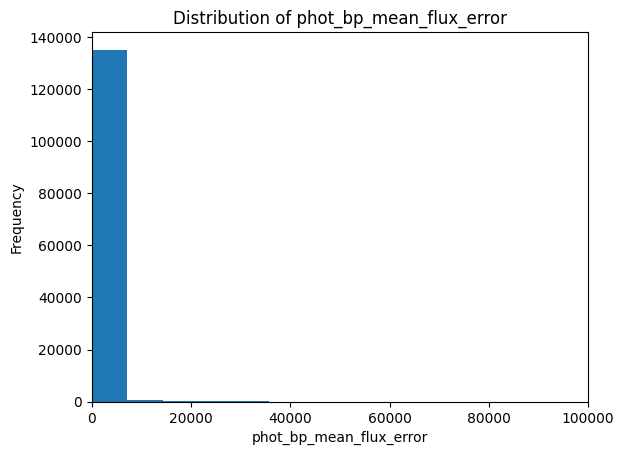

In [13]:
# plot the distribution of bp mean flux error
plt.hist(star_data['phot_bp_mean_flux_error'], bins=100)
plt.xlabel('phot_bp_mean_flux_error')
plt.ylabel('Frequency')
plt.title('Distribution of phot_bp_mean_flux_error')
plt.xlim(0, 1e5)
plt.show()


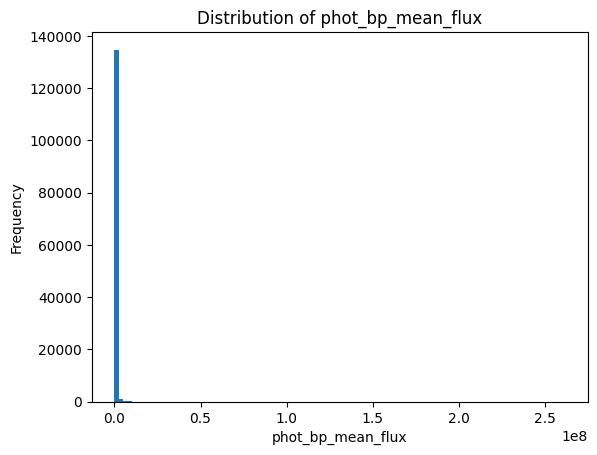

In [14]:
# plot the distribution of bp mean flux
plt.hist(star_data['phot_bp_mean_flux'], bins=100)
plt.xlabel('phot_bp_mean_flux')
plt.ylabel('Frequency')
plt.title('Distribution of phot_bp_mean_flux')
plt.show()


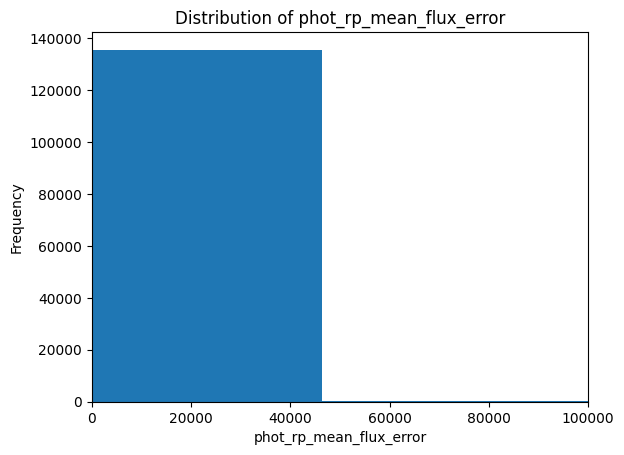

In [15]:
# plot the distribution of rp mean flux error
plt.hist(star_data['phot_rp_mean_flux_error'], bins=100)
plt.xlabel('phot_rp_mean_flux_error')
plt.ylabel('Frequency')
plt.title('Distribution of phot_rp_mean_flux_error')
plt.xlim(0, 1e5)
plt.show()


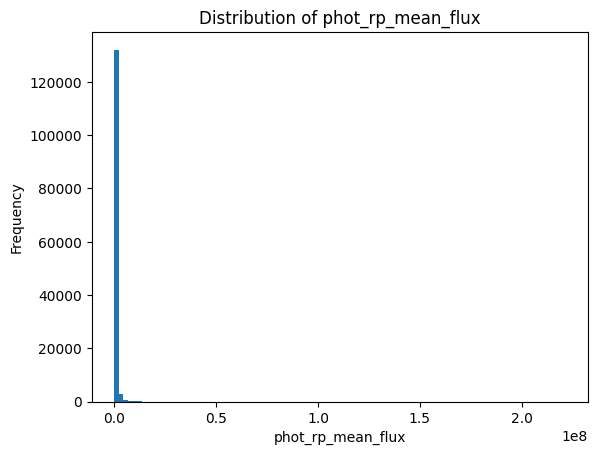

In [16]:
# plot the distribution of rp mean flux
plt.hist(star_data['phot_rp_mean_flux'], bins=100)
plt.xlabel('phot_rp_mean_flux')
plt.ylabel('Frequency')
plt.title('Distribution of phot_rp_mean_flux')
plt.show()

In [17]:
def clean_nans(input_pkl, output_pkl):    
    # open the pickles
    df = pd.read_pickle(input_pkl)

    # add a flag column if parallax is nan
    df['flagnopllx'] = np.where(df['parallax'].isnull(), 1, 0)

    # if parallax is nan, set the parallax to 0 and the error to 10
    # 10 is a large value but still normalizabe

    df.fillna({'parallax':0}, inplace=True)
    df.fillna({'parallax_error':10}, inplace=True)

    # if pmra or pmdec is nan, set the pmra to 0 and the error to 10

    df.fillna({'pmra':0}, inplace=True)
    df.fillna({'pmra_error':10}, inplace=True)
    df.fillna({'pmdec':0}, inplace=True)
    df.fillna({'pmdec_error':10}, inplace=True)

    # add a flag column if  phot_bp_mean_flux, phot_rp_mean_flux is nan
    df['flagnoflux'] = np.where(df['phot_bp_mean_flux'].isnull(), 1, 0)

    # if phot_bp_mean_flux, phot_rp_mean_flux is nan, set the flux to 0 and the error to 10
    df.fillna({'phot_bp_mean_flux':0}, inplace=True)
    df.fillna({'phot_bp_mean_flux_error':50000}, inplace=True) # 50000 is a large value but still normalizabe
    df.fillna({'phot_rp_mean_flux':0}, inplace=True)
    df.fillna({'phot_rp_mean_flux_error':50000}, inplace=True)

    # print the number of nans in each column
    print(df.isnull().sum())

    # if any nans are left, drop the row, save the obsid of dropped row,print the number of rows dropped out of the total
    na_free = df.dropna()
    only_na = df[~df.index.isin(na_free.index)]    
    print('Number of rows now:', len(na_free))
    print('Number of rows dropped:', len(df) - len(na_free), 'accounting for', ((len(df)-len(na_free))/len(df))*100, '%')

    # save the pickle
    df.to_pickle(output_pkl)
    return only_na['obsid']

obsid_drop_star = clean_nans("Pickles/allstars/star_gaia.pkl", "Pickles/allstars/star_dropna1.pkl")

obsid                      0
ra                         0
dec                        0
ra_error                   0
dec_error                  0
parallax                   0
parallax_error             0
pmra                       0
pmra_error                 0
pmdec                      0
pmdec_error                0
phot_g_mean_flux           1
phot_g_mean_flux_error     1
phot_bp_mean_flux          0
phot_bp_mean_flux_error    0
phot_rp_mean_flux          0
phot_rp_mean_flux_error    0
otype                      0
flagnopllx                 0
flagnoflux                 0
dtype: int64
Number of rows now: 136224
Number of rows dropped: 1 accounting for 0.0007340796476417691 %


# Converting fits to nparray

In [6]:
# Batch size: how many files to process before writing to the CSV
BATCH_SIZE = 10000

# Output CSV file path and folder path
output_file = 'Pickles/lamost_data.csv'
folder_path = "star_spectra/"

# Create the CSV file with headers before appending data
with open(output_file, 'w') as f:
    # Create an empty DataFrame just for headers
    columns = [f'col_{i}' for i in range(3748)] + ['file_name', 'row']
    pd.DataFrame(columns=columns).to_csv(f, index=False)

# Total number of files for the progress bar
total_files = sum([len(files) for r, d, files in os.walk(folder_path)])

# Initialize the tqdm progress bar
with tqdm(total=total_files, desc='Processing FITS files') as pbar:
    
    # Prepare a list for batch processing
    batch_list = []
    
    # Loop through each FITS file in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Open the FITS file and extract the relevant data
        with fits.open(file_path) as hdul:
            # Extract the first 3 rows and first 3748 columns
            data = hdul[0].data[:3, :3748]  # This gets the first 3 rows
            
            # Loop through the 3 rows and append them to the batch list
            for i, row_data in enumerate(data):
                # Create a dictionary with the data, label, and file name
                data_dict = {f'col_{j}': value for j, value in enumerate(row_data)}
                data_dict['file_name'] = filename  # Include file name
                data_dict['row'] = i               # Track which row from the FITS file
                
                # Append the dictionary to the batch list
                batch_list.append(data_dict)
        
        # Increment the progress bar
        pbar.update(1)

        # Write the batch to CSV if batch size is met
        if len(batch_list) >= BATCH_SIZE:
            df = pd.DataFrame(batch_list)
            df.to_csv(output_file, mode='a', header=False, index=False)
            batch_list.clear()  # Clear the batch list after writing

    # Write any remaining data in the batch at the end of the folder loop
    if batch_list:
        df = pd.DataFrame(batch_list)
        df.to_csv(output_file, mode='a', header=False, index=False)
        batch_list.clear()  # Clear the list after writing



Processing FITS files: 100%|██████████| 136178/136178 [54:16<00:00, 41.81it/s]   


In [8]:
lamost_data = pd.read_csv('Pickles/lamost_data.csv')

# Print the shape of the DataFrame
print(lamost_data.shape)

KeyboardInterrupt: 

In [10]:
# Read the first few rows of the CSV file
sample_data = pd.read_csv('Pickles/lamost_data.csv', nrows=10)
print(sample_data)

         col_0        col_1        col_2        col_3        col_4  \
0  -162.933350   474.217620  -149.057660   384.298650   816.799740   
1     0.000002     0.000002     0.000002     0.000002     0.000002   
2  3699.986300  3700.838400  3701.690700  3702.543000  3703.395800   
3   129.156890   156.821580  -211.704540   -57.861380   838.955800   
4     0.000003     0.000003     0.000003     0.000002     0.000003   
5  3699.986300  3700.838400  3701.690700  3702.543000  3703.395800   
6   760.736000  2198.241200  1996.852000  1921.712000  2894.582000   
7     0.000002     0.000002     0.000002     0.000001     0.000001   
8  3699.986300  3700.838400  3701.690700  3702.543000  3703.395800   
9  1826.645800   514.431000   -60.697970  -636.369200   553.605600   

         col_5        col_6        col_7        col_8        col_9  ...  \
0  1025.091800    97.349976  -451.699400    13.819055   455.163200  ...   
1     0.000002     0.000002     0.000002     0.000002     0.000002  ...   
2  3

In [11]:
# Define the chunk size
chunk_size = 10000

# Initialize empty DataFrames for flux and frequency values
flux_values = pd.DataFrame()
freq_values = pd.DataFrame()

# Get the total number of rows in the CSV file for the progress bar
total_rows = sum(1 for _ in open('Pickles/lamost_data.csv')) - 1  # Subtract 1 for the header row

# Read the CSV file in chunks with a progress bar
for chunk in tqdm(pd.read_csv('Pickles/lamost_data.csv', chunksize=chunk_size), total=total_rows//chunk_size):
    # Mask to filter rows based on row number
    flux_mask = chunk['row'] == 0  # Select only the flux values from the first row
    freq_mask = chunk['row'] == 2  # Select only the frequency values from the third row
    
    # Append the masked rows to the respective DataFrames
    flux_values = pd.concat([flux_values, chunk[flux_mask].drop(columns=['row'])])
    freq_values = pd.concat([freq_values, chunk[freq_mask].drop(columns=['row'])])

# Print the shape of the flux and frequency DataFrames
print(flux_values.shape, freq_values.shape)

# Save the flux and frequency DataFrames to pickle files
flux_values.to_pickle('Pickles/flux_values.pkl')
freq_values.to_pickle('Pickles/freq_values.pkl')

41it [04:57,  7.26s/it]                        


(136178, 3749) (136178, 3749)


# Interpolating the spectra and deal with nans
### If large sequence of 0 appear, then discard spectra, if small interpolate

In [ ]:
def interpolate_spectrum(fluxes_loc, frequencies_loc, output_dir, limit=10, edge_limit=20):
    """Interpolates the flux values to fill in missing data points."""
    # Load the data from the pickle file    
    df_freq = pd.read_pickle(frequencies_loc).reset_index(drop=True)      
    df_freq = df_freq.drop(columns=['row'])
    df_flux = pd.read_pickle(fluxes_loc).reset_index(drop=True)  # Reset index for zero-based iteration
    df_flux = df_flux.drop(columns=['row'])

    # Initialize an empty list to store the results before concatenating into a DataFrame
    results_list = []

    # Initialize lists to store problematic file_names
    nan_files = []  

    # Count the number of successful interpolations
    cnt_success = 0

    # Debugging counters
    cnt_total_skipped = 0
    cnt_nan_skipped = 0
    cnt_zero_skipped = 0

    # Overwrite the output file at the beginning
    if os.path.exists(output_dir):
        os.remove(output_dir)

    # Loop through each row in the DataFrame (each row is a spectrum) with tqdm for progress bar
    for index, row in tqdm(df_flux.iterrows(), total=len(df_flux), desc='Interpolating spectra'):

        # Extract the fluxes (assuming they start at column 0 and continue to the last column)
        fluxes = row[:-2].values  # Exclude the last columns (file_name, label)

        # Extract the frequencies
        frequencies = df_freq.iloc[int(index), :-2].values  # Exclude the last columns (file_name, label)

        # Count the number of NaN and 0 values in the fluxes and frequencies
        fluxes = pd.to_numeric(row[:-2], errors='coerce').values  # Exclude and convert to numeric
        frequencies = pd.to_numeric(df_freq.iloc[index, :-2], errors='coerce').values  # Same for frequencies
        num_nan = np.isnan(fluxes).sum() + np.isnan(frequencies).sum()  # Count NaN values
        num_zero = (fluxes == 0).sum() + (frequencies == 0).sum()  # Count zero values
        num_freq_nan = np.isnan(frequencies).sum() + (frequencies == 0).sum()
        if num_freq_nan > 0:
            print(f"Number of NaN or zero frequency values: {num_freq_nan}")
        # Special handling for NaN values, counting nans in sequence, except for the first and last 10
        if num_nan > limit and index > edge_limit and index < len(fluxes)-edge_limit:
            cnt_nan_skipped += 1  # Debug: count NaN-skipped rows
            nan_files.append(row['file_name'])
            continue
        
        if num_zero > limit and index > edge_limit and index < len(fluxes)-edge_limit:
            cnt_zero_skipped += 1  # Debug: count zero-skipped rows
            nan_files.append(row['file_name'])
            continue

        # Deal with NaN values
        fluxes = fluxes[~np.isnan(fluxes)]
        frequencies = frequencies[~np.isnan(fluxes)]

        # Interpolate to fill in missing values
        f = interp1d(frequencies, fluxes, kind='linear', fill_value="extrapolate")
        new_frequencies = np.linspace(frequencies.min(), frequencies.max(), len(row[:-2].values))

        # Interpolated flux values
        interpolated_fluxes = f(new_frequencies)

        # Store the interpolated data along with labels and other metadata
        # Create a dictionary for the interpolated spectrum
        interpolated_data = {f'flux_{i}': value for i, value in enumerate(interpolated_fluxes)}

        # Add the original metadata back (e.g., file_name, label, row)
        interpolated_data['file_name'] = row['file_name']
        interpolated_data['label'] = row['label']
        
        # Append the interpolated data to the results list
        results_list.append(interpolated_data)

        if index % 2000 == 0:  # Save every 5000 rows
            if os.path.exists(output_dir):
                existing_df = pd.read_pickle(output_dir)  # Load existing data
                new_df = pd.DataFrame(results_list)
                # Concatenate existing and new data
                combined_df = pd.concat([existing_df, new_df], ignore_index=True)
                combined_df.to_pickle(output_dir)  # Save combined DataFrame
            else:
                # If the file doesn't exist, create a new DataFrame and save
                pd.DataFrame(results_list).to_pickle(output_dir)
            cnt_success += len(results_list)  # Increment the count of successful interpolations
            results_list = []  # Clear list to free memory

    print(f"Initial number of rows: {len(df_flux)}")

    # After the loop, save any remaining results
    if results_list:
        if os.path.exists(output_dir):
            existing_df = pd.read_pickle(output_dir)
            new_df = pd.DataFrame(results_list)
            combined_df = pd.concat([existing_df, new_df], ignore_index=True)
            combined_df.to_pickle(output_dir)
        else:
            pd.DataFrame(results_list).to_pickle(output_dir)
        cnt_success += len(results_list)

    # Debugging information
    cnt_total_skipped = len(nan_files)
    print(f"Total successful interpolations: {cnt_success}")
    print(f"Total skipped due to NaNs: {cnt_nan_skipped}")
    print(f"Total skipped due to zeros: {cnt_zero_skipped}")
    print(f"Total skipped rows (NaNs + zeros): {cnt_total_skipped}")
    print(f"Final check: len(df_flux) == cnt_success + len(nan_files)? {len(df_flux) == cnt_success + cnt_total_skipped}")

    return nan_files


In [ ]:
# Interpolate the spectra and save the results
nan_files = interpolate_spectrum("Pickles/lamost_data_flux.pkl", "Pickles/lamost_data_freq.pkl", "Pickles/lamost_data_interpolated.pkl")